In [1]:
import sys
sys.path.append("../src/")
import numpy as np
import pandas
import json
import ot
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import glob
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import random
import tqdm
from tqdm import tqdm
import seaborn as sb
import scipy as sp
import topo_util
from topo_util import noisy_circle, noisy_disk
import sklearn as sk
import sklearn.decomposition
import math
import pd

/home/syz/miniconda3/envs/tpot/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def torus(n_samples,noise_level,radius):
    t = np.linspace(0,2*np.pi,n_samples)
    r = np.sqrt(radius*np.random.rand(n_samples))
    x = np.multiply(r,np.cos(t))
    y =  np.multiply(r,np.sin(t))
    noise = np.random.rand(n_samples,2)
    data = []
    for ii in range(n_samples):
        if r[ii] > 0.4:
            data.append([x[ii],y[ii], 0])
    noise = np.random.rand(len(data),3) 
    data = np.array(data) + noise_level*radius*noise
    return data

In [3]:
np.random.seed(42)

B = torus(400, 0.1,  1.5 )

data4 = noisy_disk(100, 0.1, 0, 0, 0.9)
data4 = [[2.6, el[0],el[1]+2] for el in data4]

data = noisy_circle(30, 0.1, 2, 0.7 ,0.5)
data = np.array([[el[0], 0, el[1]] for el in data])
for i in range(2,8):
    aaa = noisy_circle(35, 0.1, 2, 0 ,0.8)
    aaa = np.array([ [ (0.2 * i)+ (np.random.rand(1)[0]*0.2)+1, el[1],el[0] ] for el in aaa])
    data = np.concatenate([data,aaa])
data = np.concatenate([data, data4])  

data = [[el[1],el[2],-el[0]] for el in data]
data = np.array(data)
A = data

In [4]:
A.shape, B.shape


((340, 3), (349, 3))

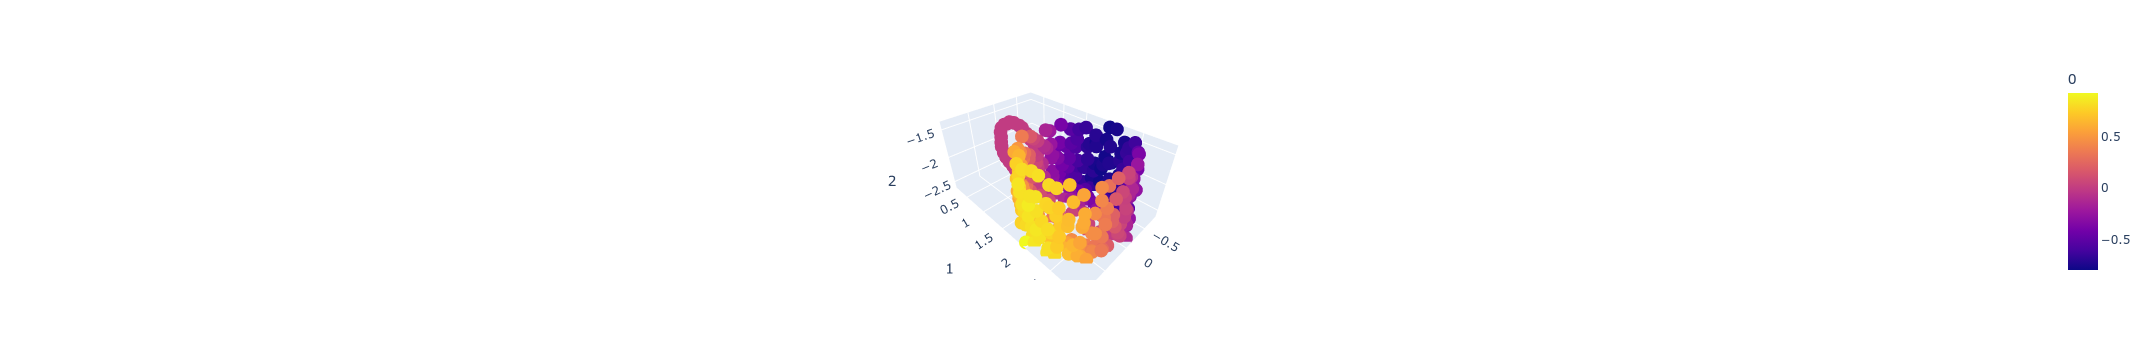

In [5]:
df = pandas.DataFrame(A)
fig = px.scatter_3d(df, x=0, y=1, z=2,  color = 0
)
fig.update_scenes(aspectmode='data')

fig.show()

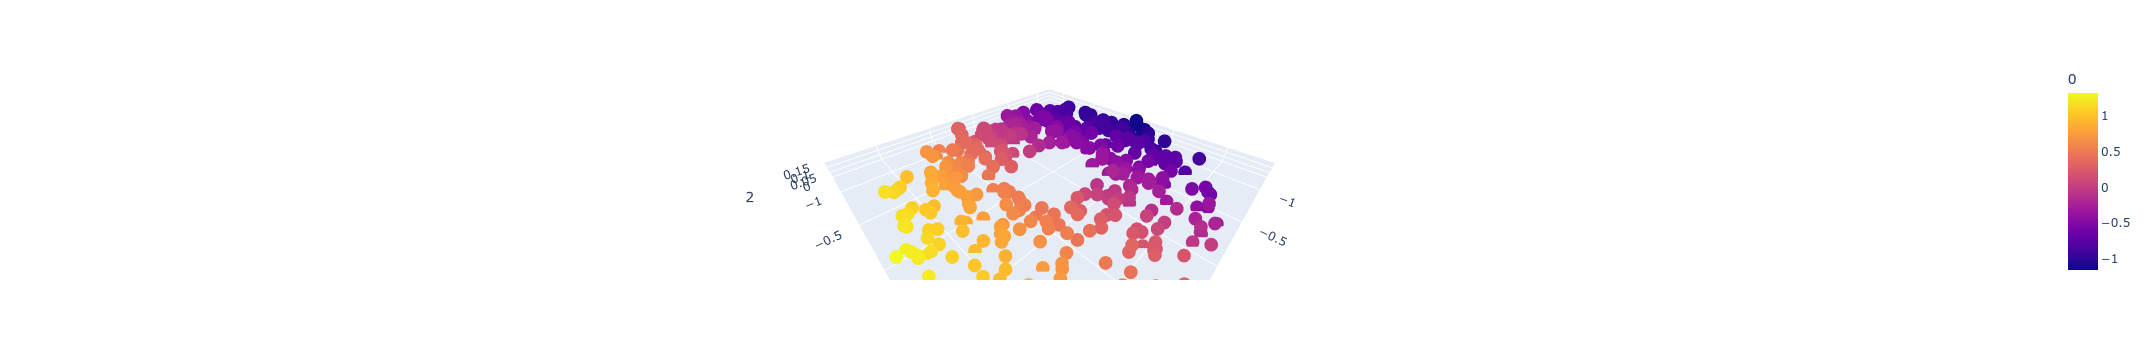

In [6]:
df = pandas.DataFrame(B)
fig = px.scatter_3d(df, x=0, y=1, z=2,  color = 0
)
fig.update_scenes(aspectmode='data')

fig.show()

In [7]:
# C1 = sp.spatial.distance.cdist(A, A, "sqeuclidean")
# C2 = sp.spatial.distance.cdist(B, B, "sqeuclidean")
# C1 /= np.median(C1)
# C2 /= np.median(C2)
C1 = sp.spatial.distance.cdist(A, A, metric = "sqeuclidean"); C1 /= np.mean(C1)
C1 = np.exp(-C1)
C2 = sp.spatial.distance.cdist(B, B, metric = "sqeuclidean"); C2 /= np.mean(C2)
C2 = np.exp(-C2)

In [8]:
p_dis = ot.unif(len(A))
q_dist = ot.unif(len(B))

gw0, log0 = ot.gromov.gromov_wasserstein(
    C1, C2, p_dis, q_dist, 'square_loss', verbose=True, log=True)
print('Gromov-Wasserstein distances: ' + str(log0['gw_dist']))

It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.473757e-01|0.000000e+00|0.000000e+00
    1|1.272879e-01|1.578134e-01|2.008774e-02
    2|8.357987e-02|5.229496e-01|4.370806e-02
    3|5.765804e-02|4.495787e-01|2.592183e-02
    4|3.595462e-02|6.036340e-01|2.170343e-02
    5|2.020711e-02|7.793048e-01|1.574750e-02
    6|1.838887e-02|9.887757e-02|1.818247e-03
    7|1.810368e-02|1.575293e-02|2.851860e-04
    8|1.806333e-02|2.233769e-03|4.034931e-05
    9|1.805724e-02|3.373729e-04|6.092024e-06
   10|1.805552e-02|9.508373e-05|1.716786e-06
   11|1.805482e-02|3.904407e-05|7.049336e-07
   12|1.805446e-02|1.964243e-05|3.546336e-07
   13|1.805419e-02|1.512452e-05|2.730610e-07
   14|1.805395e-02|1.330592e-05|2.402245e-07
   15|1.805379e-02|8.801056e-06|1.588924e-07
   16|1.805350e-02|1.611187e-05|2.908757e-07
   17|1.805208e-02|7.871770e-05|1.421018e-06
   18|1.805031e-02|9.806907e-05|1.770177e-06
   19|1.804937e-02|5.205865e-05|9.396258e-07
It. 

In [9]:
def centre(i, pc):
    if i < 30:
        return  - pc[i][2]
    else:
        return pc[i][2] +1

color = np.array([centre(i, A) for i in range(len(A))] )

def handle(el):
    if el[1] < 1.3:
        return el[1]
    else:
        return el[1]+3

color = np.array([handle(A[i]) for i in range(len(A))] )

In [10]:
def set_axes_equal(ax):
    """Make axes of 3D plot have equal scale."""
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()
    
    x_range = abs(x_limits[1] - x_limits[0])
    y_range = abs(y_limits[1] - y_limits[0])
    z_range = abs(z_limits[1] - z_limits[0])
    
    max_range = max(x_range, y_range, z_range)
    
    x_mid = np.mean(x_limits)
    y_mid = np.mean(y_limits)
    z_mid = np.mean(z_limits)
    
    ax.set_xlim3d([x_mid - max_range / 2, x_mid + max_range / 2])
    ax.set_ylim3d([y_mid - max_range / 2, y_mid + max_range / 2])
    ax.set_zlim3d([z_mid - max_range / 2, z_mid + max_range / 2])

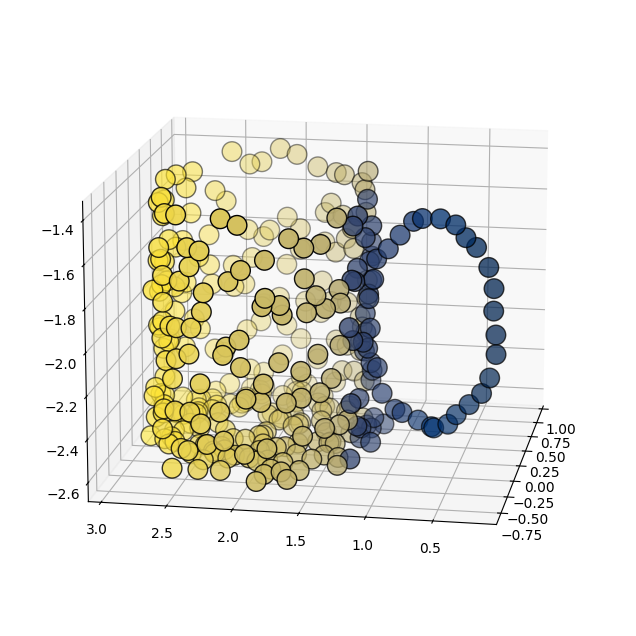

In [11]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
scat = ax.scatter(A[:,0],A[:,1],A[:,2], 
                    marker='o', 
                    s=200,
                    c = color,
                    cmap = 'cividis',
                    vmax=max(color), vmin=min(color), edgecolor = 'k'
                 )
# set_axes_equal(ax)
ax.view_init(elev=15, azim=190, roll=0)
plt.savefig('../outputs/mug.svg')

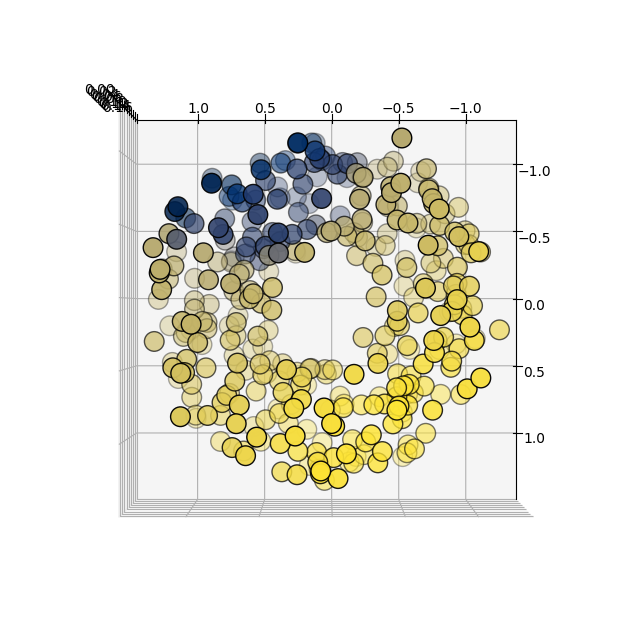

In [12]:
P = gw0.T / gw0.sum(axis=0)[:, np.newaxis]
p_gromov = np.matmul(P, color)

fig = plt.figure()

ax = fig.add_subplot(projection='3d')

scat = ax.scatter(B[:,0],B[:,1],B[:,2], 
                    marker='o', 
                    s=200,
                    c = p_gromov,
                    cmap = 'cividis',
                    vmax=max(color), vmin=min(color), edgecolor = 'k')
ax.view_init(elev=270, azim=0, roll=0)
# set_axes_equal(ax)
plt.savefig('../outputs/torus_GW.svg')

In [13]:
import hypernetx as hnx
import tpot

def PH(X):
    df = pandas.DataFrame()
    for ii in range(X.shape[1]):
        df['x_{}'.format(ii)] =  X[:,ii]
    df.to_csv("pointcloud.tsv", sep = '\t', index = False)
    !julia ../src/PH.jl 
    with open('PH.json','r') as f:
        dic = json.load(f)
    return dic  
H_all = [PH(x) for x in tqdm([A,B])]

/home/syz/miniconda3/envs/tpot/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:23<00:00, 11.89s/it]


In [14]:
df1 = topo_util.make_dataframe(H_all[0]["barcode"])
df2 = topo_util.make_dataframe(H_all[1]["barcode"])

In [15]:
# filter on PH 
# def length_filter(x, idx):
#     return {"barcode" : [[x['barcode'][0][i] for i in idx], [x['barcode'][1][i] for i in idx]],
#             "representatives" : [x['representatives'][i] for i in idx]}
# idx0=np.where(df1.Length > df1.Length.quantile(0.7))[0]
# H_all[0]=length_filter(H_all[0], idx0); df1=df1.loc[idx0, :]
# idx1=np.where(df2.Length > df2.Length.quantile(0.7))[0]
# H_all[1]=length_filter(H_all[1], idx1);
# df2=df2.loc[idx1, :]

In [16]:
p_spt = df1.iloc[:, 0:2].to_numpy()
q_spt = df2.iloc[:, 0:2].to_numpy()

G_all = [hnx.Hypergraph({str(i) : k for (i, k) in enumerate(g['representatives'])}) for g in H_all]

y0, w0, v0 = topo_util.process_hg(G_all[0], A.shape[0])
y1, w1, v1 = topo_util.process_hg(G_all[1], B.shape[0])

# similarity with kernel
h = 0.25
K0 = topo_util.get_kernel(A, h)
L0 = topo_util.symmetric_laplacian(K0)
K0 /= K0.sum(-1).reshape(-1, 1)
K1 = topo_util.get_kernel(B, h)
L1 = topo_util.symmetric_laplacian(K1)
K1 /= K1.sum(-1).reshape(-1, 1)

y0_imputed = topo_util.impute_laplacian(y0, L0)
y1_imputed = topo_util.impute_laplacian(y1, L1) 

y0 = y0_imputed; y1 = y1_imputed;

In [17]:
p, q = pd.augmented_weights(p_spt, q_spt)
C = pd.augmented_cost(p_spt, q_spt)
pi = ot.emd(p, q, C)

In [18]:
C_v0 = sp.spatial.distance.cdist(A, A, metric = "sqeuclidean"); C_v0 /= np.mean(C_v0)
C_v0 = np.exp(-C_v0)
C_v1 = sp.spatial.distance.cdist(B, B, metric = "sqeuclidean"); C_v1 /= np.mean(C_v1)
C_v1 = np.exp(-C_v1)
C_pd = pd.augmented_cost(p_spt, q_spt); C_pd /= np.mean(C_pd)

In [35]:
alpha = 0.5
beta = 2.5
v0 = p
v1 = q
w0 = ot.unif(y0.shape[0])
w1 = ot.unif(y1.shape[0])
pi_s, pi_f, _, = tpot.TPOT(y0, y1, w0, w1, v0, v1,
                          C_v0, C_v1, C_pd, 
                          alpha = alpha, beta = beta, iter = 250, print_iter = 10, 
                          eps_s = 0.01, eps_f = 0.01, 
                          solver = "sinkhorn", 
                          )
P = (pi_s / pi_s.sum(axis=-1)[:, np.newaxis])
Q = (pi_f[:-1, :-1] / pi_f[:-1, :-1].sum(axis=-1)[:, np.newaxis])
Q_pd = pi[:-1, :-1] / pi[:-1, :-1].sum(axis=-1)[:, np.newaxis]
Q[np.isnan(Q)] = 0
Q_pd[np.isnan(Q_pd)] = 0
P = (pi_s / pi_s.sum(axis=-1)[:, np.newaxis])
pp_to = np.matmul(P.T, color)

Iteration 0,	 obj = 0.07407257787900962,	 obj_terms = {'coot': 0.012459354319964398, 'ot': 0.025737268176245862, 'gw': 0.035875955382799356}
Iteration 10,	 obj = 0.06884592766073222,	 obj_terms = {'coot': 0.012294439980521876, 'ot': 0.02572560379585158, 'gw': 0.030825883884358765}
Iteration 20,	 obj = 0.062115721321492456,	 obj_terms = {'coot': 0.012138163601851694, 'ot': 0.025734002378495702, 'gw': 0.02424355534114506}
Iteration 30,	 obj = 0.06129254257627009,	 obj_terms = {'coot': 0.012092629408679108, 'ot': 0.025740387309396685, 'gw': 0.023459525858194302}
Iteration 40,	 obj = 0.061152856321226245,	 obj_terms = {'coot': 0.012066544952523527, 'ot': 0.025743582312230007, 'gw': 0.02334272905647271}
Iteration 50,	 obj = 0.061071550408847736,	 obj_terms = {'coot': 0.012050982037435168, 'ot': 0.02574522215844459, 'gw': 0.023275346212967975}
Iteration 60,	 obj = 0.061031109382273005,	 obj_terms = {'coot': 0.012043098431510841, 'ot': 0.02574583369542379, 'gw': 0.023242177255338368}
Iteratio

/tmp/ipykernel_2265727/1295059061.py:15: RuntimeWarning:

invalid value encountered in divide



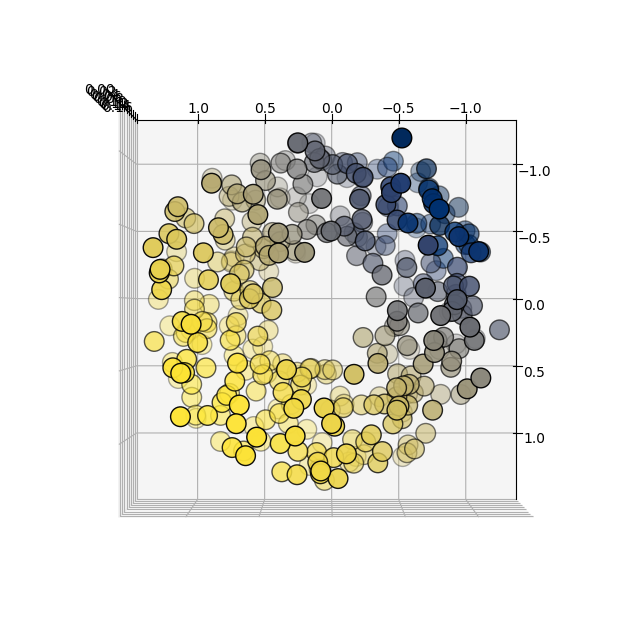

In [37]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
scat = ax.scatter(B[:,0],B[:,1],B[:,2], 
                marker='o', 
                s=200,
                c = pp_to,
                cmap = 'cividis',
                edgecolor = 'k')

ax.view_init(elev=270, azim=0, roll=0)
plt.savefig('../outputs/mug_target_tpot_alpha{}_beta{}.svg'.format(alpha,beta))

In [25]:
# sizes_p = 40 + np.zeros((len(p_spt)))
# sizes_q = 40 + np.zeros((len(q_spt)))
# sizes_p[-1] = 100
# sizes_q[-1] = 100
# color_p =  1+np.zeros((len(p_spt)))
# color_q =  2+np.ones((len(q_spt)))

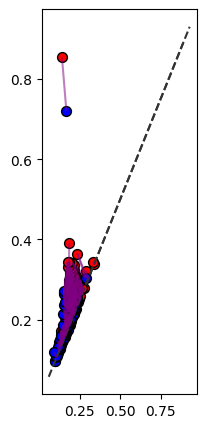

In [26]:
plt.figure(figsize = (2, 5))
# pd.plot_pd(p, q, p_spt, q_spt, pi_f, color_p, color_q, sizes_p, sizes_q)
pd.plot_pd(p_spt, color = 'red'); pd.plot_pd(q_spt, color = 'blue')
pd.plot_pd_connections(p, q, p_spt, q_spt, pi_f)
plt.savefig('../outputs/mug_diagrams.svg'.format(alpha,beta), dpi=300)